In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
from matplotlib.colors import LogNorm

In [3]:
path = "/data/OWN/paramstest/e01_t20/output_00041"
SF1= wkbl.Galaxy_Hound(path,"halo,stars,gas")
print "loaded"
SF1.r_virial(600)
print "cutted"
nucenter = nbe.real_center(SF1.dm.pos3d, SF1.dm.mass)
SF1.center_shift(nucenter)
SF1.redefine(4.5)

loading Dark matter..
loading Stars..
loading Gas..
loaded
| r_200 = 231.4453125
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.442e+12 M_sun
| p_dm_200      =  9.289e+05 particles
| stellar mass  =  1.318e+11 M_sun
| p_st_200      =  4.688e+06 psrticles
| gas mass      =  1.412e+11 M_sun
| p_gs_200      =  2.091e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |22, 0, 0|
| D =| 0,19, 0|
|    | 0, 0, 1|
cutted


In [4]:
ok,SF1.dm.rho,_= CF.getDensity(np.array(SF1.dm.pos3d.reshape(len(SF1.dm.pos3d)*3),
                                    dtype=np.float32), SF1.dm.mass)


In [5]:
path = "/data/OWN/SF1test/SF0/output_00041"
SF0= wkbl.Galaxy_Hound(path,"halo,stars,gas")
print "loaded"
SF0.r_virial(600)
print "cutted"
nucenter = nbe.real_center(SF0.dm.pos3d, SF0.dm.mass)
SF0.center_shift(nucenter)
SF0.redefine(4.5)

loading Dark matter..
loading Stars..
loading Gas..
loaded
| r_200 = 230.2734375
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.439e+12 M_sun
| p_dm_200      =  9.267e+05 particles
| stellar mass  =  1.022e+11 M_sun
| p_st_200      =  4.403e+05 psrticles
| gas mass      =  1.700e+11 M_sun
| p_gs_200      =  2.323e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |17, 0, 0|
| D =| 0,16, 0|
|    | 0, 0, 1|
cutted


In [6]:
ok,SF0.dm.rho,_= CF.getDensity(np.array(SF0.dm.pos3d.reshape(len(SF0.dm.pos3d)*3),
                                    dtype=np.float32), SF0.dm.mass)

<IPython.core.display.Javascript object>


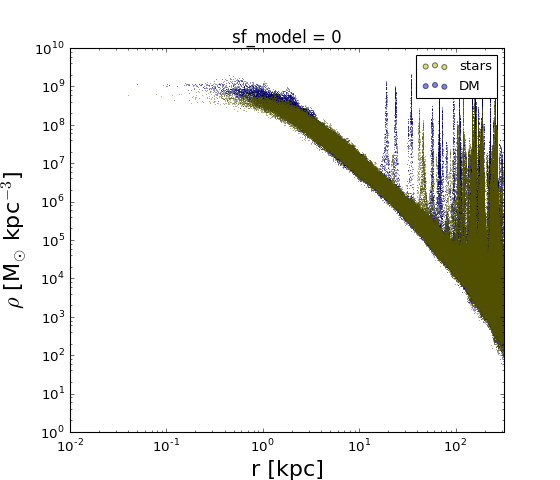

In [7]:
fig, ax= plt.subplots(figsize=[7,6])
ax.set_xlim([1e-2,10**2.5])
ax.set_ylim([1,1e10])
ax.scatter(1e20,1e20,c='y',alpha=0.5, label="stars")
ax.scatter(1e20,1e20,c='b',alpha=0.5, label="DM")
ax.scatter(SF1.dm.r, SF1.dm.rho,s=0.5,alpha=0.5,lw=0,c='b')
ax.scatter(SF0.dm.r, SF0.dm.rho,s=0.5,alpha=0.5,lw=0,c='y')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
ax.set_title("sf_model = 0",fontsize=15)
####
legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)

In [8]:
def face_on_dm(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.dm.pos3d[:,0], 
                                       sim.dm.pos3d[:,1],
                                       bins=(edges, edges),
                                       weights=sim.dm.mass)
    result = H.T
    return result, edges

def face_on_st(sim,lims,points,thikness=.5):
    disk = (np.abs(sim.st.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[disk,0], 
                                       sim.st.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.st.mass[disk])
    result = H.T
    return result, edges

def face_on_gs(sim,lims,points,thikness=.9):
    disk = (np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disk,0], 
                                       sim.gs.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.gs.mass[disk])
    result = H.T
    return result, edges

def edge_on_st(sim,lims,points):
    #disk = sim.st.pos3d[:,2]
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[:,0], 
                                       sim.st.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=sim.st.mass)
    result = H.T
    return result, edges
    
def edge_on_gs(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=sim.gs.mass)
    result = H.T
    return result, edges
    

In [9]:
# Moster et all
def M_1(z):
    M10 ,M11 = 11.590, 1.195
    log = M10 + M11*(z / (z+1))
    return 10**(log)

def N(z):
    N10 ,N11 = 0.0351, -0.0247
    return N10 + N11*(z / (z+1))


def beta(z):
    B10 ,B11 = 1.376, -0.826
    return B10 + B11*(z / (z+1))


def gamma(z):
    G10 ,G11 = 0.608, 0.329
    return G10 + G11*(z / (z+1))

def mm(M,z=0):
    one = ( M / M_1(z))**(-beta(z))
    two = ( M / M_1(z))**gamma(z)
    return 2*N(z) * M / (one +two)

def alpha(m):
    return 0.15 / np.log10(m)

M = np.logspace(10,14,50)
m = mm(M)
al = np.sqrt(m)#alpha(m)

<IPython.core.display.Javascript object>


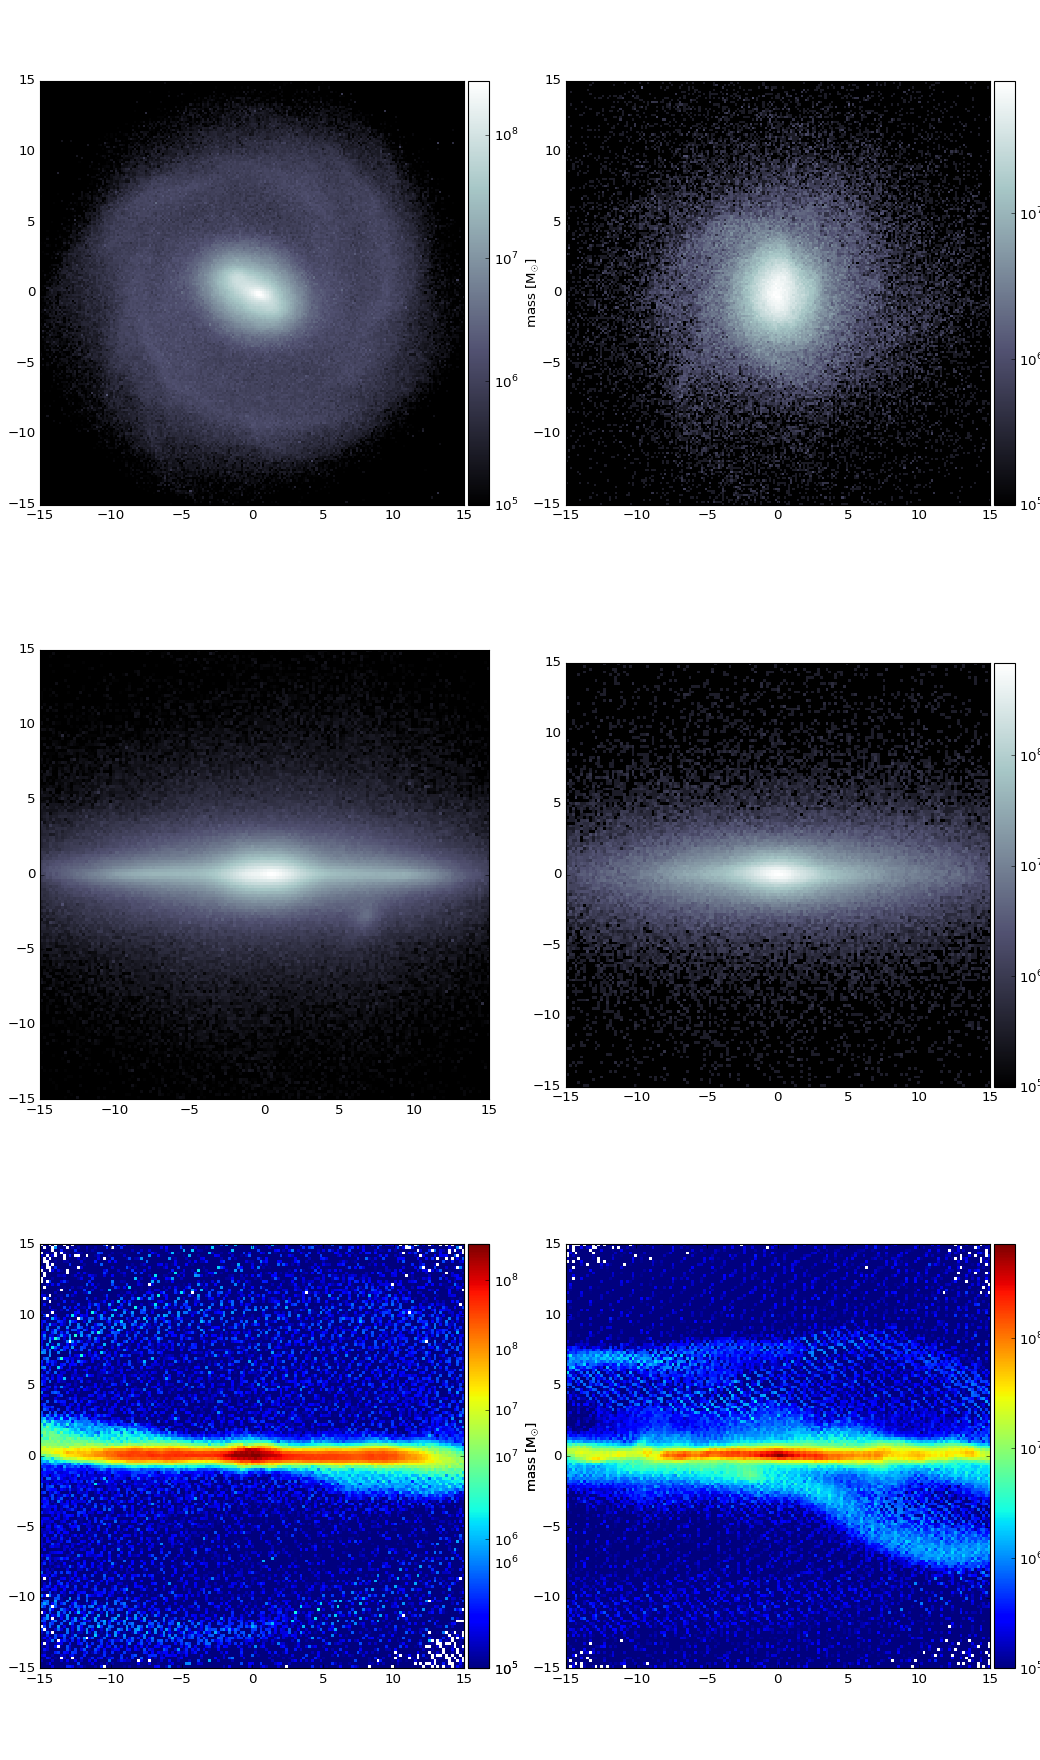

In [10]:
length = 15. 
fig,[[ax,ax1],[ax3,ax4],[ax2,ax5]] = plt.subplots(3,2,figsize=[13,22])
fig.tight_layout(w_pad=3)

#######################################################################################################################3

SF1_faceOn,edges = face_on_st(SF1,[-length,length],200)#H.T 

mass_1 = ax.imshow(SF1_faceOn+1e3, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

#ax.text(-100,1.1*SF1_140.r200,r"R$_{200}$ = "+str(int(SF1_140.r200))+" Kpc ",color='w',fontsize=15)
#######################################################################################################################3

SF0_faceOn,edges = face_on_st(SF0,[-length,length],200)#H.T 

mass_2 = ax1.imshow(SF0_faceOn+1e3, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
#######################################################################################################################3

SF1_edgeOn,edges = edge_on_st(SF1,[-length,length],150)#H.T 


mass_2 = ax3.imshow(SF1_edgeOn+1e3, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

SF0_edgeOn,edges = edge_on_st(SF0,[-length,length],150)#H.T 

mass_2 = ax4.imshow(SF0_edgeOn+1e5, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )

divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

#######################################################################################################################3

SF1_edgeOn,edges = edge_on_gs(SF1,[-length,length],150)#H.T 


mass_2 = ax2.imshow(SF1_edgeOn, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
#######################################################################################################################3

SF0_edgeOn,edges = edge_on_gs(SF0,[-length,length],150)#H.T 


mass_2 = ax5.imshow(SF0_edgeOn, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )

divider = make_axes_locatable(ax5)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')



<IPython.core.display.Javascript object>


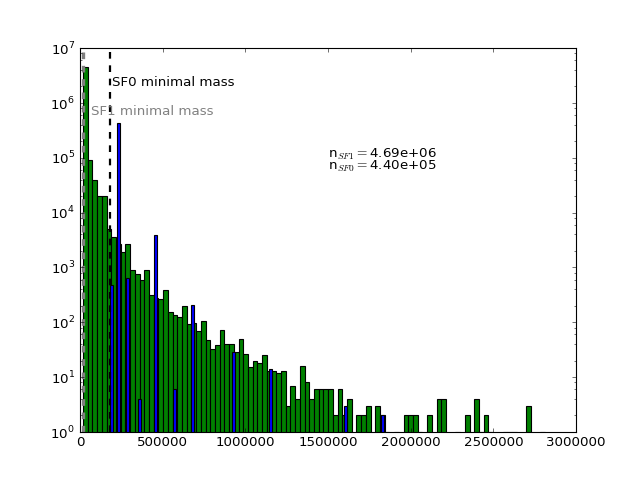

In [11]:
sf0_hist = np.histogram(SF0.st.mass,
                        bins=np.arange(SF0.st.mass.min(),SF0.st.mass.max(),(SF0.st.mass.max()-SF0.st.mass.min())/100.))
sf1_hist = np.histogram(SF1.st.mass,
                        bins=np.arange(SF1.st.mass.min(),SF1.st.mass.max(),(SF1.st.mass.max()-SF1.st.mass.min())/100.))
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.bar(sf1_hist[1][:-1],sf1_hist[0],width=sf1_hist[1][1]-sf1_hist[1][0],color='g')
ax.bar(sf0_hist[1][:-1],sf0_hist[0],width=sf0_hist[1][1]-sf0_hist[1][0],color='b')
ax.axvline(x=SF0.st.mass.min(),c='k',ls='--',lw=2)
ax.text(SF0.st.mass.min()+1e4,2e6,"SF0 minimal mass")
ax.axvline(x=SF1.st.mass.min(),c='gray',ls='--',lw=3)
ax.text(SF1.st.mass.min()+5e4,6e5,"SF1 minimal mass",color='gray')
ax.text(1.5e6,1e5,r"n$_{SF1} = $"+"{0:1.2e}".format(len(SF1.st.mass)))
ax.text(1.5e6,6e4,r"n$_{SF0} = $"+"{0:1.2e}".format(len(SF0.st.mass)))

In [12]:
def face_on_st_mass(sim,lims,points,mass_min=0,mass_max=3e6):
    disk = (sim.st.mass[:]>mass_min)&(sim.st.mass[:]<mass_max)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[disk,0], 
                                       sim.st.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.st.mass[disk])
    result = H.T
    return result, edges

<IPython.core.display.Javascript object>


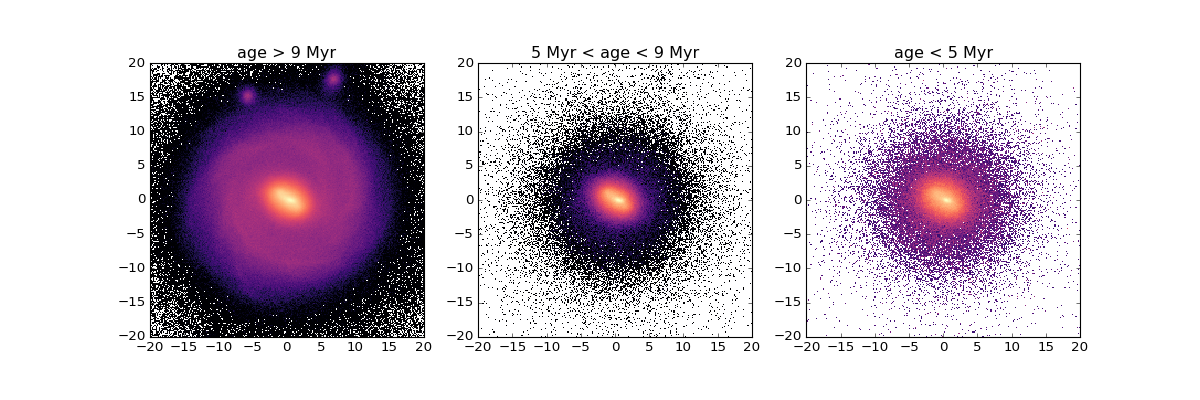

In [13]:
length = 20
fig, ax = plt.subplots(1,3,figsize=[15,5])
#titles
ax[0].set_title("age > 9 Myr")
ax[1].set_title("5 Myr < age < 9 Myr")
ax[2].set_title("age < 5 Myr")
# generate histogram
young_st_face, edges = face_on_st_mass(SF1,[-length,length],250,mass_max=2.3e4)#H.T
mass_1 = ax[0].imshow(young_st_face, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )
# generate histogram
old_st_face, edges = face_on_st_mass(SF1,[-length,length],250,mass_min=2.3e4,mass_max=6e4)#H.T

mass_1 = ax[1].imshow(old_st_face, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                      )
old_st_face, edges = face_on_st_mass(SF1,[-length,length],250,mass_min=6e4)#H.T

mass_1 = ax[2].imshow(old_st_face, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e4)
                      )